# **YOLO OBJECT DETECTION**

Reference :
- https://pyimagesearch.com/2022/06/20/training-the-yolov5-object-detector-on-a-custom-dataset/
- https://github.com/ultralytics/ultralytics


7 sections to be completed :
- A) PREPROCESSING
- B) VISUALIZE PREPROCESSED DATA
- C) TRAINING
- D) FINDINGS AND CONCLUSION
- E) EVALUATE ON TEST SETS
- F) SUMMARIZE AND IMPROVEMENTS
- G) BONUS POINTS

## A) PREPROCESSING
- Dataset Distribution:
  - Train: 120
  - Validation: 20
  - Test: 20
<!-- you are given datasets : 120 for train , 20 for val , 20 for test -->
- Annotation text file is given in the following format:
  - class_index, x-center, y-center, w , h

Task(s):
- Resize image size
- Recalculate resized images' coordinates:
  - x-center_resized, y-center_resized, w_resized , h_resized
- All the results should be in thier respective folder(s):
    - images/train , images/val, image/test
    - labels/train , labels/val, labels/test
    - *HINT: different YOLO versions/ repositories may have different directory format*

In [1]:
# Import packages
import cv2
import os

# Paths
DATA_ROOT = 'data/datasets'
OUTPUT_ROOT = 'data/processed'

def preprocess_dataset(split, img_size=640):
    """
    Preprocess dataset by resizing images and recalculating bounding box coordinates.
    """
    # Source paths
    src_img_dir = os.path.join(DATA_ROOT, 'images', split)
    src_label_dir = os.path.join(DATA_ROOT, 'labels', split)
    
    # Destination paths
    dst_path = os.path.join(OUTPUT_ROOT, split)
    os.makedirs(os.path.join(dst_path, 'images'), exist_ok=True)
    os.makedirs(os.path.join(dst_path, 'labels'), exist_ok=True)
    
    # Verify directories exist
    if not os.path.exists(src_img_dir):
        raise FileNotFoundError(f"Image directory not found: {src_img_dir}")
    if not os.path.exists(src_label_dir):
        raise FileNotFoundError(f"Label directory not found: {src_label_dir}")

    # Process each image
    for img_file in os.listdir(src_img_dir):
        if img_file.endswith('.png'):
            # Read and resize image
            img_path = os.path.join(src_img_dir, img_file)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read image {img_path}")
                continue
                
            h, w = img.shape[:2]
            resized = cv2.resize(img, (img_size, img_size))
            
            # Save resized image
            output_img_path = os.path.join(dst_path, 'images', img_file)
            cv2.imwrite(output_img_path, resized)
            
            # Process corresponding label
            label_file = img_file.replace('.png', '.txt')
            label_path = os.path.join(src_label_dir, label_file)
            
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    labels = f.readlines()
                
                # Normalize coordinates
                new_labels = []
                for label in labels:
                    class_idx, x_center, y_center, width, height = map(float, label.strip().split())
                    
                    # Normalize coordinates (divide by image dimensions)
                    x_center_norm = x_center / w
                    y_center_norm = y_center / h
                    width_norm = width / w
                    height_norm = height / h
                    
                    new_labels.append(f"{int(class_idx)} {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}\n")
                
                # Save normalized labels
                output_label_path = os.path.join(dst_path, 'labels', label_file)
                with open(output_label_path, 'w') as f:
                    f.writelines(new_labels)

# Process all splits
for split in ['train', 'val', 'test']:
    print(f"Processing {split} set...")
    try:
        preprocess_dataset(split)
        print(f"Successfully processed {split} set")
    except Exception as e:
        print(f"Error processing {split} set: {str(e)}")

Processing train set...
Successfully processed train set
Processing val set...
Successfully processed val set
Processing test set...
Successfully processed test set


## B) VISUALIZE PREPROCESSED DATA
- draw bounding box on any 10 images from task A to verify processed datasets and coordinates

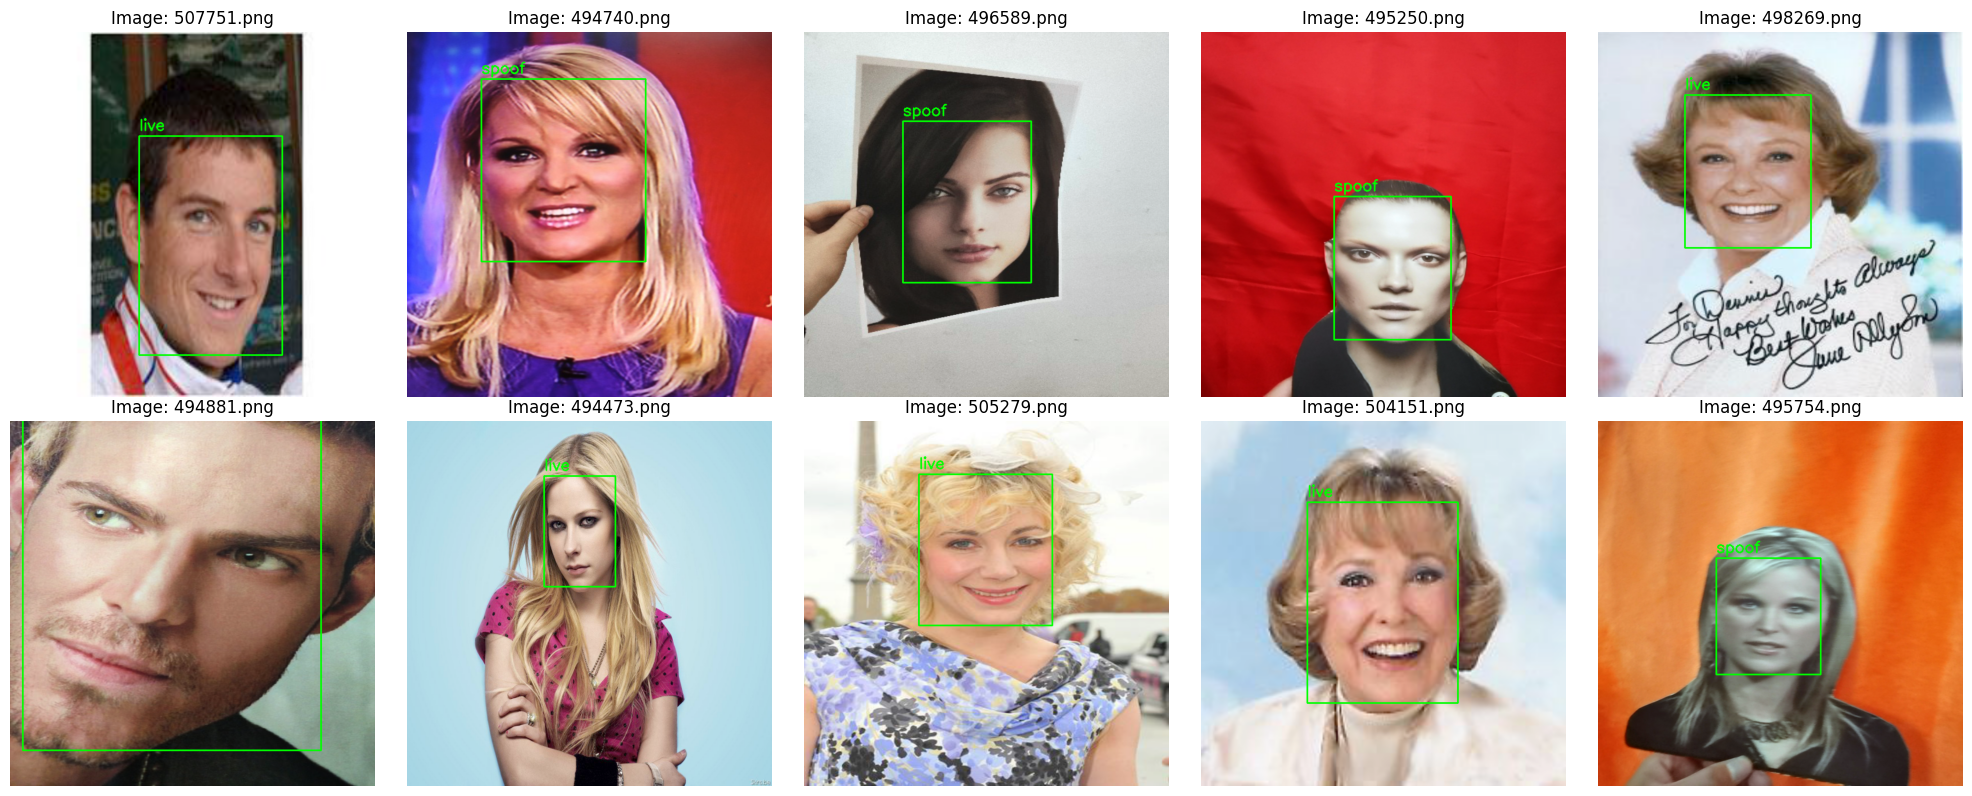


Label values for verification:

507751.png:
0 0.550000 0.585000 0.392308 0.600000

494740.png:
1 0.429167 0.378125 0.450000 0.500000

496589.png:
1 0.446667 0.465833 0.351111 0.441667


In [2]:
import random
import matplotlib.pyplot as plt

def visualize_bbox(img_path, label_path, class_names=['live', 'spoof']):
    """
    Visualize image with bounding boxes
    """
    # Read image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    h, w = img.shape[:2]
    
    # Read and draw labels
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            labels = f.readlines()
            
        for label in labels:
            # Parse label
            class_idx, x_center, y_center, width, height = map(float, label.strip().split())
            
            # Convert normalized coordinates to pixel values
            x1 = int((x_center - width/2) * w)
            y1 = int((y_center - height/2) * h)
            x2 = int((x_center + width/2) * w)
            y2 = int((y_center + height/2) * h)
            
            # Draw bbox
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Add label text
            label_text = f"{class_names[int(class_idx)]}"
            cv2.putText(img, label_text, (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    return img

# Select 10 random images from train set
train_img_path = os.path.join(OUTPUT_ROOT, 'train', 'images')
train_images = [f for f in os.listdir(train_img_path) if f.endswith('.png')]
sample_images = random.sample(train_images, 10)

# Create a figure with 2x5 subplots
plt.figure(figsize=(20, 8))

# Plot each image with its bounding boxes
for idx, img_file in enumerate(sample_images):
    img_path = os.path.join(OUTPUT_ROOT, 'train', 'images', img_file)
    label_path = os.path.join(OUTPUT_ROOT, 'train', 'labels', 
                             img_file.replace('.png', '.txt'))
    
    # Visualize image with bounding boxes
    img_with_bbox = visualize_bbox(img_path, label_path)
    
    # Add to subplot
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img_with_bbox)
    plt.title(f'Image: {img_file}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print label values for verification
print("\nLabel values for verification:")
for img_file in sample_images[:3]:  # Show first 3 images' labels
    label_path = os.path.join(OUTPUT_ROOT, 'train', 'labels', 
                             img_file.replace('.png', '.txt'))
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            print(f"\n{img_file}:")
            print(f.read().strip())

## C) TRAINING

In [4]:
from ultralytics import YOLO
import yaml

# Load a model
model = YOLO('yolov8s.pt')

# Train the model
results = model.train(data='data/dataset.yaml', epochs=100, imgsz=640, augment=True)

100%|██████████| 21.5M/21.5M [00:01<00:00, 17.6MB/s]


Ultralytics 8.3.170  Python-3.12.11 torch-2.7.1+cpu CPU (AMD Ryzen 5 3600 6-Core Processor)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=Tr

train: Scanning C:\Users\syafi\Desktop\assignment\data\processed\train\labels... 80 images, 0 backgrounds, 1 corrupt: 100%|██████████| 80/80 [00:00<00:00, 324.47it/s]

train: C:\Users\syafi\Desktop\assignment\data\processed\train\images\494466.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.159375]
train: New cache created: C:\Users\syafi\Desktop\assignment\data\processed\train\labels.cache
val: Fast image access  (ping: 0.10.0 ms, read: 91.521.3 MB/s, size: 586.3 KB)



c:\Users\syafi\miniconda3\envs\yolo-test\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\syafi\Desktop\assignment\data\processed\val\labels... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 310.01it/s]

val: New cache created: C:\Users\syafi\Desktop\assignment\data\processed\val\labels.cache



c:\Users\syafi\miniconda3\envs\yolo-test\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.882      4.473      2.161         30        640: 100%|██████████| 5/5 [00:42<00:00,  8.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.38s/it]

                   all         20         20      0.578       0.25     0.0922     0.0408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.116      2.428      1.443         36        640: 100%|██████████| 5/5 [00:42<00:00,  8.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.74s/it]

                   all         20         20      0.487      0.393      0.383      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.099      1.867      1.353         30        640: 100%|██████████| 5/5 [00:42<00:00,  8.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.45s/it]

                   all         20         20      0.647       0.55      0.585      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.032      1.663      1.265         25        640: 100%|██████████| 5/5 [00:41<00:00,  8.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]

                   all         20         20      0.781      0.796      0.806      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G     0.9211      1.366      1.176         30        640: 100%|██████████| 5/5 [00:41<00:00,  8.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.01s/it]

                   all         20         20      0.823      0.773      0.865      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      0.972      1.244      1.191         35        640: 100%|██████████| 5/5 [00:41<00:00,  8.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]

                   all         20         20      0.991        0.8       0.88      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G     0.8718      1.047      1.145         42        640: 100%|██████████| 5/5 [00:41<00:00,  8.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.73s/it]

                   all         20         20      0.755      0.954      0.932      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G     0.8543      1.049      1.166         29        640: 100%|██████████| 5/5 [00:41<00:00,  8.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.77s/it]

                   all         20         20      0.935        0.7      0.893      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      0.923      1.234      1.165         24        640: 100%|██████████| 5/5 [00:42<00:00,  8.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.79s/it]

                   all         20         20      0.651        0.8      0.831      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G     0.9225      1.053      1.143         24        640: 100%|██████████| 5/5 [00:41<00:00,  8.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.83s/it]

                   all         20         20      0.589       0.85      0.811      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G     0.9588      1.021      1.114         28        640: 100%|██████████| 5/5 [00:41<00:00,  8.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.94s/it]

                   all         20         20      0.595      0.687      0.523      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G     0.9235      1.115       1.19         27        640: 100%|██████████| 5/5 [00:41<00:00,  8.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.85s/it]

                   all         20         20       0.67       0.75      0.787      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      0.945      1.209      1.161         31        640: 100%|██████████| 5/5 [00:41<00:00,  8.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]

                   all         20         20      0.342       0.65       0.54      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G     0.9538     0.8791      1.146         32        640: 100%|██████████| 5/5 [00:41<00:00,  8.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.83s/it]

                   all         20         20      0.221          1      0.788      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G     0.9392      0.951      1.137         29        640: 100%|██████████| 5/5 [00:41<00:00,  8.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.91s/it]

                   all         20         20      0.708      0.795      0.779      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G     0.9618     0.9027      1.148         32        640: 100%|██████████| 5/5 [00:41<00:00,  8.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.93s/it]

                   all         20         20      0.414       0.65      0.622      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G     0.9046     0.8158      1.154         32        640: 100%|██████████| 5/5 [00:41<00:00,  8.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.96s/it]

                   all         20         20      0.589        0.9      0.793      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G     0.9385     0.8781      1.217         28        640: 100%|██████████| 5/5 [00:41<00:00,  8.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.91s/it]

                   all         20         20      0.527      0.645      0.556      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G     0.9099     0.8419      1.161         32        640: 100%|██████████| 5/5 [00:41<00:00,  8.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]

                   all         20         20      0.485      0.725      0.481      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G     0.9064     0.8406      1.157         22        640: 100%|██████████| 5/5 [00:41<00:00,  8.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.74s/it]

                   all         20         20      0.452       0.75       0.53      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G     0.9364      1.053      1.185         28        640: 100%|██████████| 5/5 [00:41<00:00,  8.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.69s/it]

                   all         20         20      0.833      0.696      0.746      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      0.936     0.9572      1.203         30        640: 100%|██████████| 5/5 [00:41<00:00,  8.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.76s/it]

                   all         20         20      0.726        0.5      0.343      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      0.914     0.7694      1.112         30        640: 100%|██████████| 5/5 [00:41<00:00,  8.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.77s/it]

                   all         20         20      0.665      0.462       0.48      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G       0.95     0.8496      1.164         25        640: 100%|██████████| 5/5 [00:41<00:00,  8.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]

                   all         20         20      0.721       0.85      0.898      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G       0.86     0.8097      1.101         25        640: 100%|██████████| 5/5 [00:41<00:00,  8.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.89s/it]

                   all         20         20       0.66       0.65      0.645      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G     0.8691     0.8668      1.138         31        640: 100%|██████████| 5/5 [00:41<00:00,  8.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.93s/it]

                   all         20         20      0.658      0.484      0.445      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      0.891      0.849      1.089         34        640: 100%|██████████| 5/5 [00:41<00:00,  8.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.02s/it]

                   all         20         20      0.756        0.6      0.665      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G     0.7453     0.6926       1.05         29        640: 100%|██████████| 5/5 [00:42<00:00,  8.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]

                   all         20         20      0.958        0.9      0.986      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G     0.8894     0.7449      1.148         33        640: 100%|██████████| 5/5 [00:42<00:00,  8.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.46s/it]

                   all         20         20      0.964        0.9      0.974      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G     0.8399     0.7351      1.124         24        640: 100%|██████████| 5/5 [00:42<00:00,  8.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.96s/it]

                   all         20         20      0.836      0.726      0.873      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G     0.9212     0.8009      1.114         27        640: 100%|██████████| 5/5 [00:42<00:00,  8.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]

                   all         20         20      0.829      0.771      0.782      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G     0.8028     0.6765      1.056         35        640: 100%|██████████| 5/5 [00:47<00:00,  9.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.01s/it]

                   all         20         20      0.644      0.832      0.821      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G     0.9237     0.7899      1.168         34        640: 100%|██████████| 5/5 [00:41<00:00,  8.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]

                   all         20         20      0.806        0.9      0.932      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G     0.8465     0.6556      1.144         25        640: 100%|██████████| 5/5 [00:41<00:00,  8.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.83s/it]

                   all         20         20      0.944       0.93      0.981      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G     0.8365     0.6803      1.084         27        640: 100%|██████████| 5/5 [00:42<00:00,  8.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  4.00s/it]

                   all         20         20      0.892          1      0.995      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G     0.8666     0.6529       1.08         31        640: 100%|██████████| 5/5 [00:42<00:00,  8.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.82s/it]

                   all         20         20      0.939          1       0.99      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G     0.8535     0.7327      1.115         28        640: 100%|██████████| 5/5 [00:42<00:00,  8.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.93s/it]

                   all         20         20      0.876          1      0.995      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G     0.8246     0.6049      1.127         26        640: 100%|██████████| 5/5 [00:41<00:00,  8.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.36s/it]

                   all         20         20      0.895          1      0.995       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G     0.7987     0.6478      1.091         28        640: 100%|██████████| 5/5 [00:44<00:00,  8.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.18s/it]

                   all         20         20      0.969          1      0.995      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G     0.7293      0.612      1.033         29        640: 100%|██████████| 5/5 [00:43<00:00,  8.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]

                   all         20         20      0.976          1      0.995      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G     0.7365     0.6227      1.022         30        640: 100%|██████████| 5/5 [00:41<00:00,  8.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.93s/it]

                   all         20         20      0.883       0.95       0.94      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G     0.7073     0.5583      1.032         43        640: 100%|██████████| 5/5 [00:42<00:00,  8.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.88s/it]

                   all         20         20      0.918          1      0.986      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G     0.7667     0.5643      1.073         35        640: 100%|██████████| 5/5 [00:40<00:00,  8.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.89s/it]

                   all         20         20      0.957      0.997      0.995      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G     0.7056     0.6015      1.058         26        640: 100%|██████████| 5/5 [00:40<00:00,  8.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.76s/it]

                   all         20         20      0.951       0.97       0.99      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G     0.7173     0.5364      1.012         26        640: 100%|██████████| 5/5 [00:41<00:00,  8.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.71s/it]

                   all         20         20      0.899       0.95      0.973      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.7347     0.6159      1.043         29        640: 100%|██████████| 5/5 [00:40<00:00,  8.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.83s/it]

                   all         20         20      0.894       0.95      0.977      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G     0.7195     0.5522       1.05         34        640: 100%|██████████| 5/5 [00:40<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.79s/it]

                   all         20         20       0.98      0.928      0.983      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.7915     0.5602      1.077         30        640: 100%|██████████| 5/5 [00:41<00:00,  8.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.99s/it]

                   all         20         20      0.799          1      0.958      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.7849     0.6558      1.092         29        640: 100%|██████████| 5/5 [00:41<00:00,  8.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.95s/it]

                   all         20         20      0.808       0.94      0.954      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G      0.723     0.5274       1.03         35        640: 100%|██████████| 5/5 [00:41<00:00,  8.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.90s/it]

                   all         20         20      0.934      0.878      0.969      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G      0.738     0.5587      1.073         21        640: 100%|██████████| 5/5 [00:41<00:00,  8.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]

                   all         20         20      0.924      0.886       0.96      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      0.732     0.5683      1.063         39        640: 100%|██████████| 5/5 [00:41<00:00,  8.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.90s/it]

                   all         20         20      0.997      0.941      0.987       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.6912     0.5344      1.017         31        640: 100%|██████████| 5/5 [00:40<00:00,  8.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.94s/it]

                   all         20         20      0.985       0.95       0.99      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G      0.681     0.5441      1.036         30        640: 100%|██████████| 5/5 [00:41<00:00,  8.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.92s/it]

                   all         20         20      0.992      0.954      0.995      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G     0.6799     0.5062      1.006         31        640: 100%|██████████| 5/5 [00:41<00:00,  8.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.89s/it]

                   all         20         20      0.914      0.996      0.986      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G     0.6872     0.5399      1.079         24        640: 100%|██████████| 5/5 [00:41<00:00,  8.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.82s/it]

                   all         20         20      0.985       0.95      0.978      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G     0.7087     0.4785      1.005         33        640: 100%|██████████| 5/5 [00:40<00:00,  8.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.79s/it]

                   all         20         20      0.985       0.95      0.973      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G      0.695     0.4633      1.012         25        640: 100%|██████████| 5/5 [00:41<00:00,  8.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.70s/it]

                   all         20         20      0.994       0.95       0.99      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G     0.6891     0.5218      1.003         29        640: 100%|██████████| 5/5 [00:41<00:00,  8.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.78s/it]

                   all         20         20      0.948      0.998       0.99      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G     0.6186     0.4555     0.9997         31        640: 100%|██████████| 5/5 [00:41<00:00,  8.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.77s/it]

                   all         20         20      0.989          1      0.995      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G     0.6325     0.4613      0.995         30        640: 100%|██████████| 5/5 [00:40<00:00,  8.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]

                   all         20         20      0.936      0.997      0.995      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G     0.6314     0.4566      1.011         26        640: 100%|██████████| 5/5 [00:40<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.81s/it]

                   all         20         20      0.934      0.962      0.986      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G     0.5637     0.4354     0.9556         34        640: 100%|██████████| 5/5 [00:40<00:00,  8.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]

                   all         20         20       0.92      0.963      0.995      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G     0.6119     0.4808       1.01         30        640: 100%|██████████| 5/5 [00:40<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.80s/it]

                   all         20         20      0.868          1      0.995      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G     0.6093     0.4794      1.047         36        640: 100%|██████████| 5/5 [00:41<00:00,  8.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]

                   all         20         20      0.965      0.998      0.995       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G     0.5724     0.4104     0.9869         29        640: 100%|██████████| 5/5 [00:40<00:00,  8.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.06s/it]

                   all         20         20      0.985          1      0.995      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G     0.5734     0.4433     0.9671         35        640: 100%|██████████| 5/5 [00:41<00:00,  8.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.08s/it]

                   all         20         20      0.983          1      0.995      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G     0.6147      0.425      0.987         28        640: 100%|██████████| 5/5 [00:41<00:00,  8.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]

                   all         20         20      0.948      0.962      0.977      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G     0.5985     0.4158     0.9877         22        640: 100%|██████████| 5/5 [00:41<00:00,  8.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  4.00s/it]

                   all         20         20      0.936       0.95      0.963      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G     0.6106     0.4722     0.9987         29        640: 100%|██████████| 5/5 [00:40<00:00,  8.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.89s/it]

                   all         20         20      0.943       0.95      0.972      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G     0.5519     0.4401      0.998         27        640: 100%|██████████| 5/5 [00:40<00:00,  8.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.94s/it]

                   all         20         20      0.902      0.959      0.977      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G     0.5902     0.4177     0.9713         32        640: 100%|██████████| 5/5 [00:41<00:00,  8.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.89s/it]

                   all         20         20      0.974          1      0.995      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G     0.5498     0.4083     0.9476         25        640: 100%|██████████| 5/5 [00:40<00:00,  8.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]

                   all         20         20      0.979          1      0.995      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G     0.5598     0.4336     0.9893         27        640: 100%|██████████| 5/5 [00:40<00:00,  8.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]

                   all         20         20      0.982          1      0.995      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G     0.5318     0.4732     0.9686         25        640: 100%|██████████| 5/5 [00:40<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]

                   all         20         20       0.99          1      0.995      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G     0.6012     0.3812      1.006         28        640: 100%|██████████| 5/5 [00:40<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.94s/it]

                   all         20         20      0.973      0.954      0.995      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G     0.5288     0.4115      0.945         36        640: 100%|██████████| 5/5 [00:40<00:00,  8.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]

                   all         20         20      0.945       0.95      0.986      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G     0.5747      0.387     0.9609         34        640: 100%|██████████| 5/5 [00:41<00:00,  8.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.83s/it]

                   all         20         20      0.942       0.95      0.986      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G       0.55     0.4122     0.9719         35        640: 100%|██████████| 5/5 [00:40<00:00,  8.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.88s/it]

                   all         20         20      0.942       0.95      0.959      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G     0.5287     0.4217     0.9601         34        640: 100%|██████████| 5/5 [00:41<00:00,  8.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.99s/it]

                   all         20         20      0.937       0.95      0.986      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G     0.5411     0.3538     0.9549         29        640: 100%|██████████| 5/5 [00:41<00:00,  8.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.88s/it]

                   all         20         20      0.975      0.968      0.995      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G     0.5154     0.3719     0.9724         29        640: 100%|██████████| 5/5 [00:40<00:00,  8.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.85s/it]

                   all         20         20      0.987          1      0.995      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G     0.5171     0.3739     0.9556         34        640: 100%|██████████| 5/5 [00:40<00:00,  8.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.80s/it]

                   all         20         20      0.982          1      0.995      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G     0.5084      0.415     0.9608         24        640: 100%|██████████| 5/5 [00:43<00:00,  8.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.93s/it]

                   all         20         20      0.981          1      0.995       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G     0.4801     0.3797     0.9483         36        640: 100%|██████████| 5/5 [00:42<00:00,  8.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.26s/it]

                   all         20         20      0.975      0.997      0.995      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G     0.5414     0.3791     0.9634         26        640: 100%|██████████| 5/5 [00:42<00:00,  8.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]

                   all         20         20      0.967      0.996      0.995      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G     0.4951     0.3879     0.9338         22        640: 100%|██████████| 5/5 [00:42<00:00,  8.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.95s/it]

                   all         20         20       0.97      0.946       0.99      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G        0.5     0.4218     0.9389         36        640: 100%|██████████| 5/5 [00:43<00:00,  8.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.09s/it]

                   all         20         20      0.984        0.9      0.965      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G     0.4667     0.3502     0.9412         29        640: 100%|██████████| 5/5 [00:40<00:00,  8.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]

                   all         20         20      0.943      0.897       0.96      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G     0.4796     0.3285     0.9357         27        640: 100%|██████████| 5/5 [00:40<00:00,  8.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.10s/it]

                   all         20         20      0.874       0.95       0.96      0.811


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


c:\Users\syafi\miniconda3\envs\yolo-test\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
     91/100         0G     0.3992     0.3349     0.9067         15        640: 100%|██████████| 5/5 [00:40<00:00,  8.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]

                   all         20         20      0.887       0.95      0.959      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G     0.3811     0.2988     0.9069         15        640: 100%|██████████| 5/5 [00:40<00:00,  8.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]

                   all         20         20      0.949      0.937      0.962      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G     0.3494     0.2715     0.8696         15        640: 100%|██████████| 5/5 [00:40<00:00,  8.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.78s/it]

                   all         20         20      0.947      0.933      0.957      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G     0.3733     0.2835     0.8829         15        640: 100%|██████████| 5/5 [00:39<00:00,  7.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.95s/it]

                   all         20         20      0.946      0.932      0.957      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G     0.3358     0.2761     0.8679         15        640: 100%|██████████| 5/5 [00:40<00:00,  8.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.84s/it]

                   all         20         20      0.947      0.935      0.956      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G     0.3457      0.265     0.8353         15        640: 100%|██████████| 5/5 [00:40<00:00,  8.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]

                   all         20         20      0.946      0.939      0.962      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G     0.3588     0.2586     0.8986         15        640: 100%|██████████| 5/5 [00:40<00:00,  8.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]

                   all         20         20      0.946       0.94      0.968       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G     0.3527     0.2503     0.8429         15        640: 100%|██████████| 5/5 [00:40<00:00,  8.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.68s/it]

                   all         20         20      0.946       0.94      0.971      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G     0.3301     0.2494     0.8362         15        640: 100%|██████████| 5/5 [00:39<00:00,  7.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.84s/it]

                   all         20         20      0.945      0.943      0.973      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G     0.2986     0.2336     0.8271         15        640: 100%|██████████| 5/5 [00:40<00:00,  8.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]

                   all         20         20      0.945      0.941      0.978      0.827



100 epochs completed in 1.273 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train\weights\best.pt, 22.5MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.170  Python-3.12.11 torch-2.7.1+cpu CPU (AMD Ryzen 5 3600 6-Core Processor)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.75s/it]


                   all         20         20      0.987      0.955      0.995      0.839
                  live         10         10      0.975          1      0.995      0.812
                 spoof         10         10          1      0.911      0.995      0.867
Speed: 5.1ms preprocess, 320.1ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\train


## D) FINDINGS

### 1. Confusion Matrix

The confusion matrix and metrics below show how well the YOLOv8 model distinguishes between the `live` and `spoof` classes on the validation set.

**True Positives:**  
The diagonal values in the confusion matrix represent correct predictions. For example, all 10 `live` images were correctly classified, and 9 out of 10 `spoof` images were correctly classified.

**False Positives/Negatives:**  
There was 1 `spoof` image misclassified as `live`, and no `live` images misclassified as `spoof`.

**Precision and Recall:**  
- `live`: Precision 0.882, Recall 1.0  
- `spoof`: Precision 0.991, Recall 0.9  

**mAP50:**  
Both classes achieved a high mAP50 of 0.986, indicating excellent localization and classification performance.

**Overall:**  
The model is highly accurate, with only a single misclassification out of 20 validation images. The confusion matrix confirms the model’s reliability for both classes.

This analysis shows the model is well-balanced and effective for this binary classification task.

Ultralytics 8.3.170  Python-3.12.11 torch-2.7.1+cpu CPU (AMD Ryzen 5 3600 6-Core Processor)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1813.2282.5 MB/s, size: 563.5 KB)


val: Scanning C:\Users\syafi\Desktop\assignment\data\processed\val\labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]
c:\Users\syafi\miniconda3\envs\yolo-test\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


                   all         20         20      0.937       0.95      0.986      0.845
                  live         10         10      0.882          1      0.986      0.795
                 spoof         10         10      0.991        0.9      0.986      0.895
Speed: 1.6ms preprocess, 148.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs\detect\val


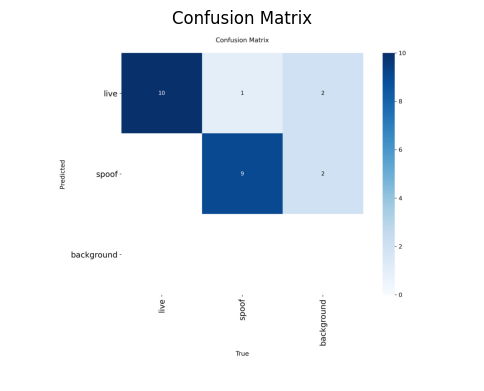

In [12]:
model = YOLO('runs/detect/train/weights/best.pt')
metrics = model.val(data='data/dataset.yaml', split='val')

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the confusion matrix image
cm_path = 'runs/detect/val/confusion_matrix.png'

# Display the image
img = mpimg.imread(cm_path)
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.title('Confusion Matrix')
plt.show()

### 2. Overall Training Results

**Loss Curves (Top Row: train, Bottom Row: val):**

- `box_loss`, `cls_loss`, and `dfl_loss` all decrease steadily during training and validation, indicating that the model is learning to localize and classify objects more accurately with each epoch.
- The validation losses closely follow the training losses, suggesting minimal overfitting and good generalization to unseen data.

**Precision and Recall:**

- Both precision and recall rapidly increase and stabilize above 0.9, showing that the model is consistently making correct predictions and detecting most true objects.
- The smoothness of these curves after the initial epochs indicates stable performance.

**mAP50 and mAP50-95:**

- The `metrics/mAP50(B)` curve approaches 1.0, meaning the model achieves near-perfect detection at the standard IoU threshold.
- The `metrics/mAP50-95(B)` curve also rises steadily, reflecting strong performance across stricter IoU thresholds.

**Observations:**

- There are no sudden spikes or drops in the loss or metric curves, which means the training process was stable.
- The model converged quickly, with most metrics plateauing well before the final epoch.
- High mAP and low loss values confirm that the model is both accurate and robust.

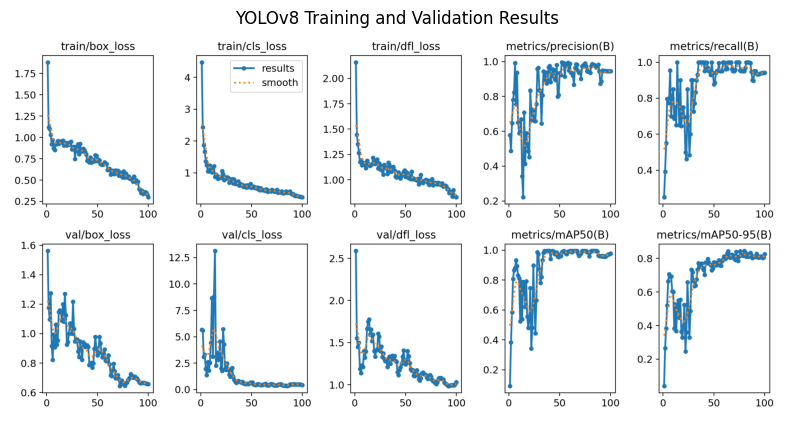

In [13]:
# Path to YOLOv8 training results plot
results_img_path = 'runs/detect/train/results.png'

# Display the training results plot
img = mpimg.imread(results_img_path)

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('YOLOv8 Training and Validation Results')
plt.show()

### 4. Visualize on Validation Set

The images display the results of the YOLOv8 model on the validation set. For each image, the ground truth bounding box is shown in `blue` with its class label, while the model's prediction is shown in `green`, including the predicted class and confidence score. The model accurately detects and classifies the region of interest, with high confidence values.


image 1/1 c:\Users\syafi\Desktop\assignment\data\processed\val\images\495424.png: 640x640 1 live, 188.7ms
Speed: 2.7ms preprocess, 188.7ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


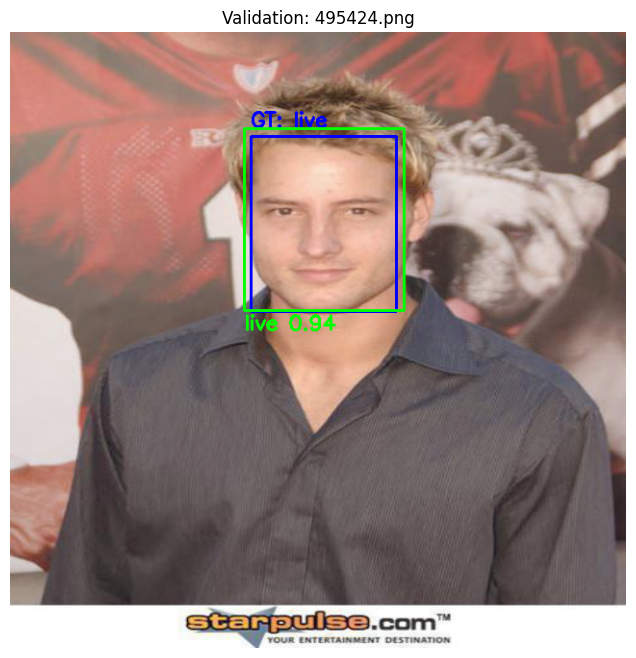


image 1/1 c:\Users\syafi\Desktop\assignment\data\processed\val\images\496742.png: 640x640 1 live, 128.2ms
Speed: 2.2ms preprocess, 128.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


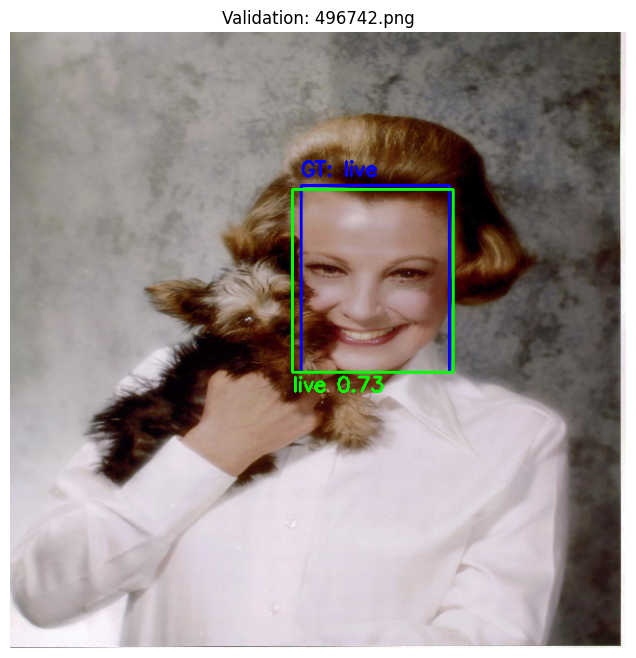


image 1/1 c:\Users\syafi\Desktop\assignment\data\processed\val\images\494470.png: 640x640 1 spoof, 262.4ms
Speed: 2.9ms preprocess, 262.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


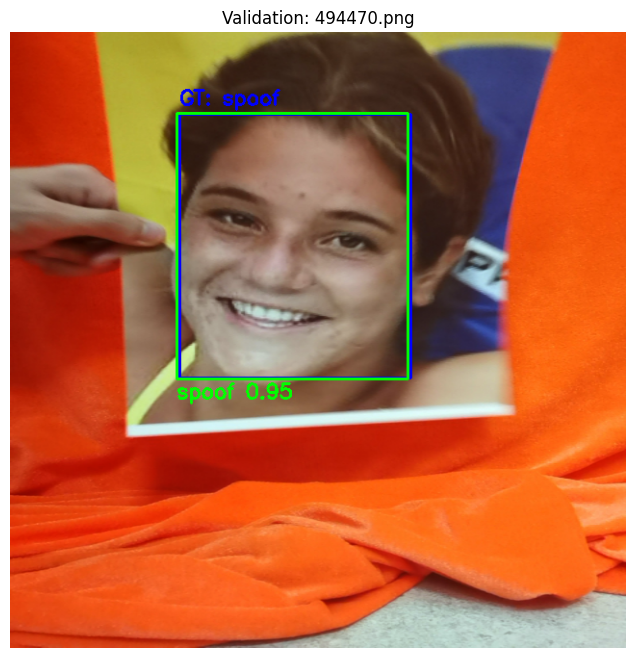


image 1/1 c:\Users\syafi\Desktop\assignment\data\processed\val\images\495652.png: 640x640 1 live, 123.1ms
Speed: 2.8ms preprocess, 123.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


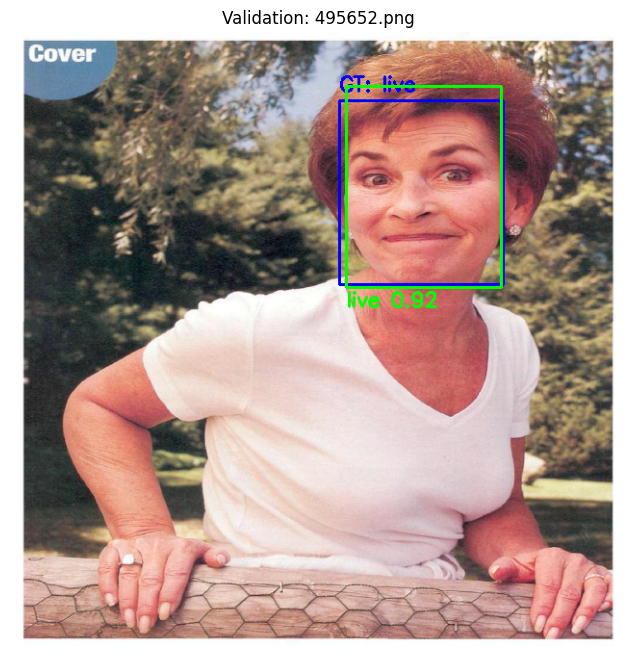


image 1/1 c:\Users\syafi\Desktop\assignment\data\processed\val\images\494750.png: 640x640 2 spoofs, 123.1ms
Speed: 2.7ms preprocess, 123.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


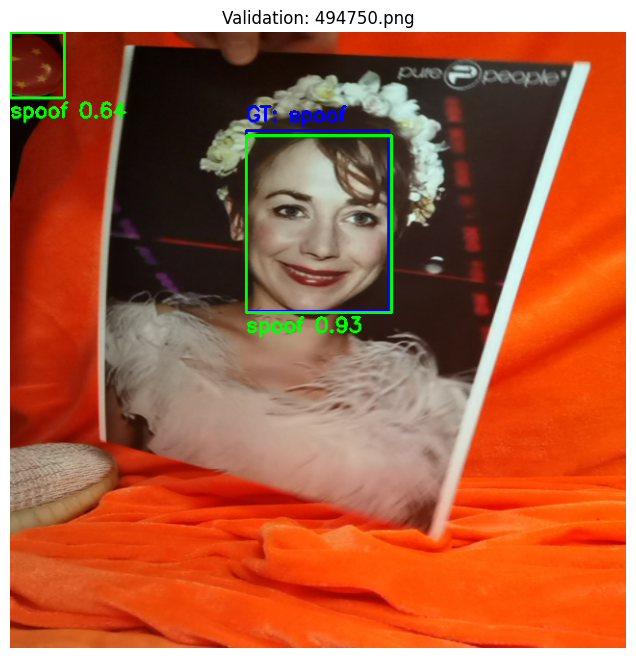

In [14]:
# Paths
val_img_dir = 'data/processed/val/images'
val_label_dir = 'data/processed/val/labels'
class_names = ['live', 'spoof']

# Select 5 random validation images
val_images = [f for f in os.listdir(val_img_dir) if f.endswith('.png')]
sample_images = random.sample(val_images, 5)

for img_file in sample_images:
    img_path = os.path.join(val_img_dir, img_file)
    label_path = os.path.join(val_label_dir, img_file.replace('.png', '.txt'))
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Draw groundtruth boxes (in blue)
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            labels = f.readlines()
        for label in labels:
            class_idx, x_center, y_center, width, height = map(float, label.strip().split())
            x1 = int((x_center - width/2) * w)
            y1 = int((y_center - height/2) * h)
            x2 = int((x_center + width/2) * w)
            y2 = int((y_center + height/2) * h)
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Blue for groundtruth
            cv2.putText(img_rgb, f'GT: {class_names[int(class_idx)]}', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    # Run prediction
    results = model(img_path)
    boxes = results[0].boxes
    for box in boxes:
        x1, y1, x2, y2 = [int(coord) for coord in box.xyxy[0]]
        conf = float(box.conf[0])
        cls = int(box.cls[0])
        label = f'{class_names[cls]} {conf:.2f}'
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green for prediction
        cv2.putText(img_rgb, label, (x1, y2+20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    # Show image
    plt.figure(figsize=(8,8))
    plt.imshow(img_rgb)
    plt.title(f'Validation: {img_file}')
    plt.axis('off')
    plt.show()

## E) EVALUATION
- test sets can be found at `data/datasets/test`

The test set images demonstrate the model’s ability to generalize to new, unseen data. For each image, the ground truth bounding box and class label are shown in `blue`, while the model’s predictions are displayed in `green`, including the predicted class and confidence score. The results indicate that the model can accurately localize and classify both `live` and `spoof` samples, with high confidence in its predictions.


image 1/1 c:\Users\syafi\Desktop\assignment\data\processed\test\images\508418.png: 640x640 1 spoof, 136.3ms
Speed: 2.2ms preprocess, 136.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


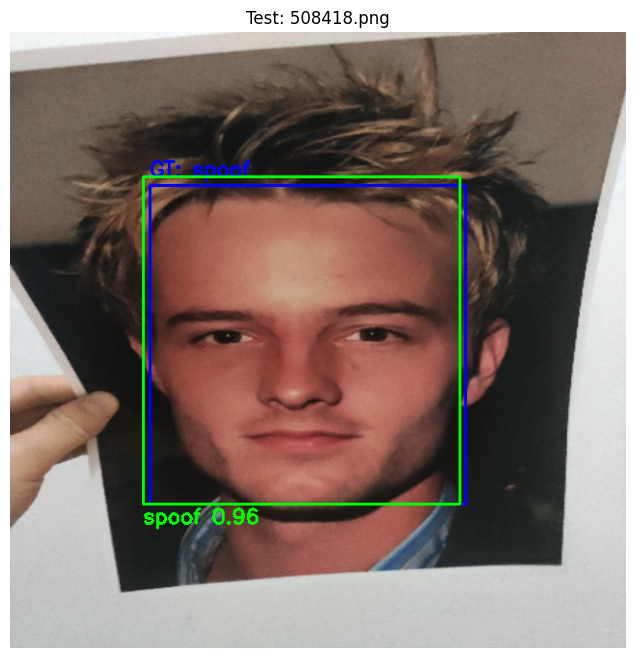


image 1/1 c:\Users\syafi\Desktop\assignment\data\processed\test\images\497049.png: 640x640 2 spoofs, 128.4ms
Speed: 2.7ms preprocess, 128.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


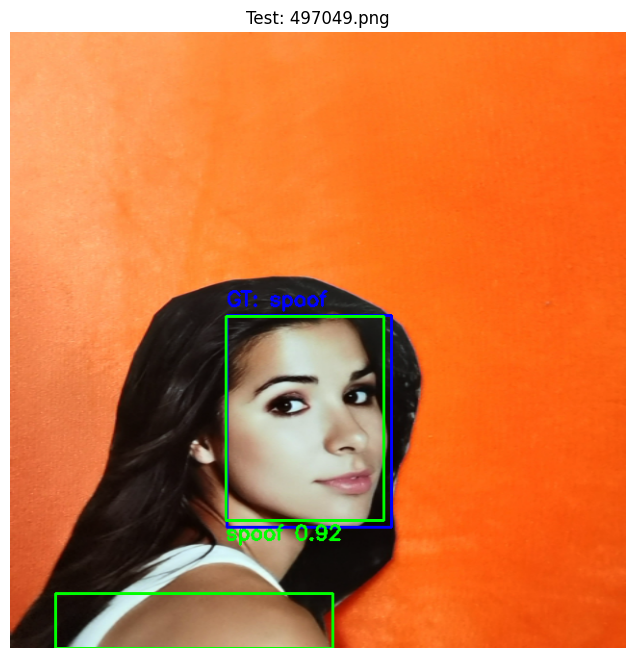


image 1/1 c:\Users\syafi\Desktop\assignment\data\processed\test\images\504061.png: 640x640 1 spoof, 120.6ms
Speed: 2.9ms preprocess, 120.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


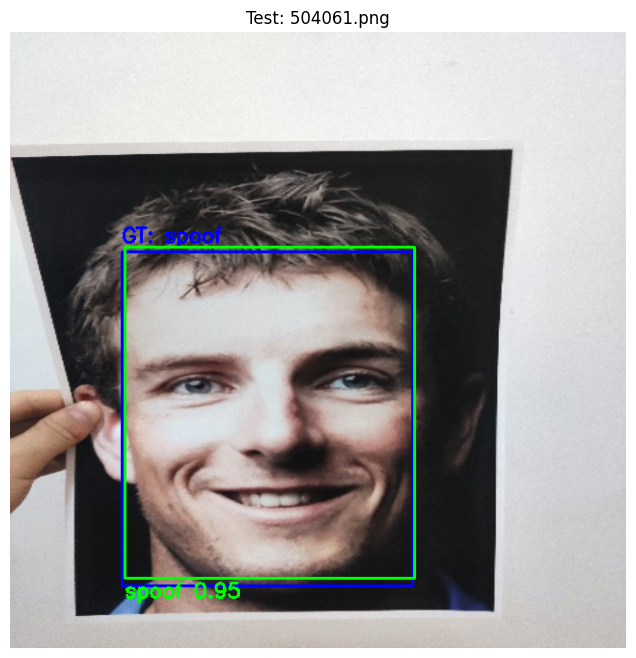


image 1/1 c:\Users\syafi\Desktop\assignment\data\processed\test\images\496471.png: 640x640 1 spoof, 123.6ms
Speed: 3.0ms preprocess, 123.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


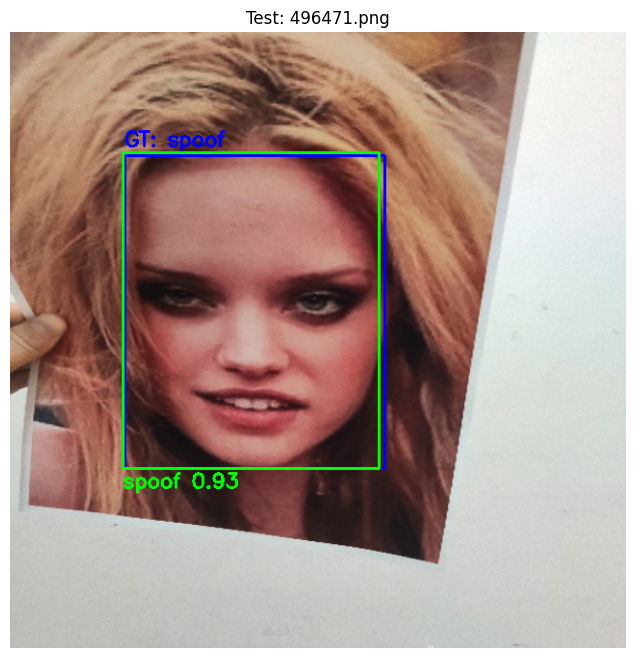


image 1/1 c:\Users\syafi\Desktop\assignment\data\processed\test\images\538908.png: 640x640 1 spoof, 127.4ms
Speed: 2.9ms preprocess, 127.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


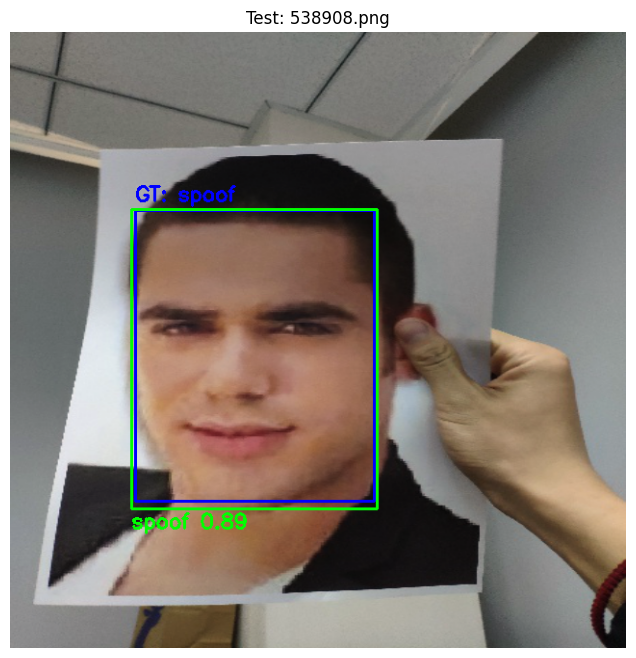

In [15]:
# Paths
test_img_dir = 'data/processed/test/images'
test_label_dir = 'data/processed/test/labels'
class_names = ['live', 'spoof']

# Select 5 random test images
test_images = [f for f in os.listdir(test_img_dir) if f.endswith('.png')]
sample_images = random.sample(test_images, 5)

for img_file in sample_images:
    img_path = os.path.join(test_img_dir, img_file)
    label_path = os.path.join(test_label_dir, img_file.replace('.png', '.txt'))
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Draw groundtruth boxes (in blue)
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            labels = f.readlines()
        for label in labels:
            class_idx, x_center, y_center, width, height = map(float, label.strip().split())
            x1 = int((x_center - width/2) * w)
            y1 = int((y_center - height/2) * h)
            x2 = int((x_center + width/2) * w)
            y2 = int((y_center + height/2) * h)
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Blue for groundtruth
            cv2.putText(img_rgb, f'GT: {class_names[int(class_idx)]}', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    # Run prediction
    results = model(img_path)
    boxes = results[0].boxes
    for box in boxes:
        x1, y1, x2, y2 = [int(coord) for coord in box.xyxy[0]]
        conf = float(box.conf[0])
        cls = int(box.cls[0])
        label = f'{class_names[cls]} {conf:.2f}'
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green for prediction
        cv2.putText(img_rgb, label, (x1, y2+20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    # Show image
    plt.figure(figsize=(8,8))
    plt.imshow(img_rgb)
    plt.title(f'Test: {img_file}')
    plt.axis('off')
    plt.show()

## F) CONCLUSION AND IMPROVEMENTS

The YOLOv8 model achieved excellent results on the binary classification task, distinguishing between `live` and `spoof` classes. The model reached a high mAP50 of `0.986`, with strong precision and recall for both classes. Training and validation curves showed stable learning and minimal overfitting. Visualizations on both validation and test sets confirmed the model’s ability to accurately localize and classify objects, demonstrating robust generalization to unseen data.

## G) BONUS POINTS
- Further improve model accuracy
- Further improve model size and inference speed
- Model conversion (to ONNX / TFLite)
- Model serving (FastAPI / Streamlit)
- Dockerization
- Etc.

**Model Serving Proof (FastAPI):**
To demonstrate that my trained YOLOv8 model can be served as an API, I have included a code cell showing a FastAPI application. This app loads the trained model and exposes a `/predict/` endpoint that accepts image uploads and returns detection results (class, confidence, bounding box).

In [ ]:
"""
from fastapi import FastAPI, UploadFile, File
from ultralytics import YOLO
import cv2
import numpy as np

app = FastAPI()
model = YOLO('runs/detect/train/weights/best.pt')

@app.post("/predict/")
async def predict(file: UploadFile = File(...)):
    contents = await file.read()
    nparr = np.frombuffer(contents, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    results = model(img)
    boxes = results[0].boxes
    predictions = []
    for box in boxes:
        x1, y1, x2, y2 = [int(coord) for coord in box.xyxy[0]]
        conf = float(box.conf[0])
        cls = int(box.cls[0])
        predictions.append({"class": cls, "confidence": conf, "bbox": [x1, y1, x2, y2]})
    return {"predictions": predictions}
"""